In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gsw import pt_from_CT,SP_from_SA,CT_from_pt,rho
from gasex._utilities import match_args_return
from gasex.phys import K0 as K0
from gasex.phys import RatmLmolK
from gasex.phys import vpress_sw, R
from gasex.sol import N2Osol_SP_pt
from metpy.calc import density # use metpy to calculate air density
from metpy.units import units
from metpy.calc import mixing_ratio_from_relative_humidity # calculate mixing ratio of water vapor in air

ImportError: cannot import name 'RatmLmolK' from 'gasex.phys' (/Users/colette/Library/CloudStorage/GoogleDrive-colette.kelly@whoi.edu/My Drive/postdoc_research/code/gasex-python/gasex/phys.py)

In [3]:
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [4]:
@match_args_return
def N2Ofugacity(SP,pt,slp=1.0,xn2o=333,units = "natm"):
    """
    Calculate the fugacity of N2O in seawater.

    Parameters:
    - SP: Practical Salinity  (PSS-78) (unitless)
    - pt: potential temperature (ITS-90) referenced
             to one standard atmosphere (0 dbar).
    - slp: Sea level pressure (atm) (default: 1.0)
    - xn2o: Mixing ratio of N2O  in dry air (ppb) (default: 333 ppb)
    - units: Units of fugacity ("natm" for nanonatmospheres, "atm" for atmospheres) (default: "natm")

    Returns:
    - f: Fugacity of N2O in the specified units
    """
    # Calculate the vapor pressure of water
    vp_sw = vpress_sw(SP,pt) # vapor pressure of water
    
    # Convert temperature to IPTS-68
    pt68 = pt * 1.00024
    y = pt68 + K0 # K0 is 0 Celsius in Kelvin, imported from phys.py

    # exponential term, Weiss and Price 1980, eqn. (11)
    eterm = -9.4563/y + 0.04739 - 6.427*10**-5*y
    
    # fugacity, Weiss and Price 1980, eqn. (7)
    f = xn2o*(slp-vp_sw)*np.exp(slp*eterm)
    
    # Convert to atmospheres if specified
    if units.lower() == "atm":
        f = f*10**-9

    return f

In [5]:
def N2OCeq(SP, pt, slp=1.0, xn2o=338, v=32.3, watervapor=True, nonideal=True):
    """
    Calculate the equilibrium concentration of N2O in seawater,
    taking into account the vapor pressure of water and non-ideal effects.

    Parameters:
    - SP: Practical Salinity (PSS-78) (unitless)
    - pt: Potential temperature (ITS-90) referenced to one standard atmosphere (0 dbar) (°C)
    - slp: Sea level pressure (atm) (default: 1.0)
    - xn2o: Mixing ratio of N2O  in dry air (ppb) (default: 333 ppb)
    - v: Partial molal volume of N2O (cm3/mol) (default: 32.3 cm3/mol, Weiss 1974)
    - watervapor: Include effect of water vapor (default: True)
    - nonideal: Include non-ideal behavior of N2O (default: True)

    Returns:
    - k0: Equilibrium constant (mol/L/atm)
    - F: Simplification of C*=K0*f*exp[(1-P)v/RT] (Weiss and Price 1980, eqn. (1)) (mol/L)
    - Ceq1: Equilibrium concentration of N2O (mol/L), including vapor pressure of water and non-ideal effects
    - Ceq2: Equilibrium concentration of N2O (mol/L), including vapor pressure of water and but excluding non-ideal effects
    - Ceq3: Equilibrium concentration of N2O (mol/L), excluding vapor pressure of water and non-ideal effects
    """   
   
    # Convert partial molal volume from cm3/mol to L/mol
    v = v/1000.0

    # Ideal gas constant (L*atm/mol/K)
    R = 0.08205691 # ideal gas constant (L*atm/mol/K)
    
    # Calculate the vapor pressure of water
    vp_sw = vpress_sw(SP,pt)

    # Convert temperature to IPTS-68
    pt68 = pt * 1.00024
    y = pt68 + K0 # K0 is 0 Celsius in Kelvin, imported from phys.py

    # Calculate equilibrium constant, mol/L/atm
    k0 = N2Osol_SP_pt(SP,pt)
    
    # Calculate exponential term 1 (Weiss and Price 1980, eqn. (11))
    eterm1 = -9.4563/y + 0.04739 - 6.427*10**-5*y
    
    # Calculate exponential term 2 (Weiss and Price 1980, eqn. (1))
    eterm2 = (1-slp)*v/(R*y)

    # Calculate F (Weiss and Price 1980, eqn. (9))
    # F is a simplification of C*=K0*f*exp[(1-P)v/RT] (Weiss and Price 1980, eqn. (1))
    F = k0*(slp-vp_sw)*np.exp(eterm1+eterm2)

    # Calculate F (Weiss and Price 1980, eqn. (9))
    # F is a simplification of C*=K0*f*exp[(1-P)v/RT] (Weiss and Price 1980, eqn. (1))
    F = k0*(slp-vp_sw)*np.exp(eterm1+eterm2)

    if (watervapor==True)&(nonideal==True):
        # Weiss and Price 1980, eqn. (8)
        Ceq = xn2o*F
    elif (watervapor==True)&(nonideal==False):
        # exclude non-ideal effects
        Ceq = k0*xn2o*(slp - vp_sw)
    elif (watervapor==False)&(nonideal==False):
        # exclude vapor pressure of water and non-ideal effects
        Ceq = k0*xn2o*slp
    elif (watervapor==False)&(nonideal==True):
        Ceq = xn2o*k0*slp*np.exp(eterm1+eterm2)
    
    return k0, F, Ceq

In [6]:
def pN2Oatm(SP,pt,slp=1.0,xn2o=338, units = "natm", v=32.3, watervapor=True, nonideal=True):
    """
    Calculate the partial pressure of N2O at the moist interface.

    Parameters:
    - SP: Practical Salinity  (PSS-78) (unitless)
    - pt: potential temperature (ITS-90) referenced
             to one standard atmosphere (0 dbar).
    - slp: Sea level pressure (atm) (default: 1.0)
    - xn2o: xn2o: Mixing ratio of N2O  in dry air (ppb) (default: 333 ppb)
    - units: Units of fugacity ("natm" for nanonatmospheres, "atm" for atmospheres) (default: "natm")
    - v: Partial molal volume of N2O (cm3/mol) (default: 32.3 cm3/mol, Weiss 1974)
    - watervapor: Include effect of water vapor (default: True)
    - nonideal: Include non-ideal behavior of N2O (default: True)

    Returns:
    - pN2Oatm: Partial pressure of N2O at the moist interface (natm or atm)
    """
    
    # Convert partial molal volume from cm3/mol to L/mol
    v = v/1000.0
    
    # Ideal gas constant (L*atm/mol/K)
    R = 0.08205691
    
    # Calculate the vapor pressure of water
    vp_sw = vpress_sw(SP,pt)
    
    # Convert temperature to IPTS-68
    pt68 = pt * 1.00024
    y = pt68 + K0 # K0 is 0 Celsius in Kelvin, imported from phys.py
    
    # Calculate exponential term 1 (Weiss and Price 1980, eqn. (11))
    eterm1 = -9.4563/y + 0.04739 - 6.427*10**-5*y

    # Calculate exponential term 2 (Weiss and Price 1980, eqn. (1))
    eterm2 = (1-slp)*v/(R*y)

    if (watervapor==True)&(nonideal==True):
        # pN2Oatm = Ceq/k0 = x'(P-pH2O)exp(P(B+2d)/RT+(1-P)v/RT)
        pN2Oatm = xn2o*(slp - vp_sw)*np.exp(eterm1+eterm2)
    elif (watervapor==True)&(nonideal==False):
        # pN2Oatm = x'(P-pH2O)
        pN2Oatm = xn2o*(slp - vp_sw)
    elif (watervapor==False)&(nonideal==False):
        # pN2Oatm = x'P
        pN2Oatm = xn2o*slp
    elif (watervapor==False)&(nonideal==True):
        # pN2Oatm = Ceq/k0 = x'(P-pH2O)exp(P(B+2d)/RT+(1-P)v/RT)
        pN2Oatm = xn2o*slp*np.exp(eterm1+eterm2)

    # Convert to atmospheres if specified
    if units.lower() == "atm":
        pN2Oatm = pN2Oatm*10**-9
    
    return pN2Oatm

In [7]:
def pN2Osw(SP,pt,C, units = "natm"):
    """
    Calculate the fugacity of N2O in seawater.

    Parameters:
    - SP: Practical Salinity  (PSS-78) (unitless)
    - pt: potential temperature (ITS-90) referenced
             to one standard atmosphere (0 dbar).
    - C: concentration (nmol/L)

    Returns:
    - pN2Osw: partial pressure of dissolved N2O (natm or atm)
    """    
    
    # Calculate equilibrium constant, mol/L/atm
    k0 = N2Osol_SP_pt(SP,pt)
    
    # calculate partial pressure of N2O in seawater (natm)
    pN2Osw = C/k0
    
    # Convert to atmospheres if specified
    if units.lower() == "atm":
        pN2Osw = pN2Osw*10**-9

    return pN2Osw

In [8]:
def xN2Osw(SP, pt, C, slp=1.0, v=32.3, watervapor=True, nonideal=True):
    """
    Calculate the mixing ratio of N2O corresponding to a given concentration in seawater.

    Parameters:
    - SP: Practical Salinity (PSS-78) (unitless)
    - pt: Potential temperature (ITS-90) referenced to one standard atmosphere (0 dbar) (°C)
    - C: Concentration of N2O (nmol/L)
    - slp: Sea level pressure (atm) (default: 1.0)
    - v: Partial molal volume of N2O (cm3/mol) (default: 32.3 cm3/mol, Weiss 1974)
    - watervapor: Include effect of water vapor (default: True)
    - nonideal: Include non-ideal behavior of N2O (default: True)

    Returns:
    - k0: Equilibrium constant (mol/L/atm)
    - F: Simplification of C*=K0*f*exp[(1-P)v/RT] (Weiss and Price 1980, eqn. (1)) (mol/L)
    - xN2O1: Mixing ratio of N2O (nmol/mol or ppb), including vapor pressure of water and non-ideal effects
    - xN2O2: Mixing ratio of N2O (nmol/mol or ppb), including vapor pressure of water and but excluding non-ideal effects
    - xN2O3: Mixing ratio of N2O (nmol/mol or ppb), excluding vapor pressure of water and non-ideal effects
    """  
   
    # Convert partial molal volume from cm3/mol to L/mol
    v = v/1000.0

    # Ideal gas constant (L*atm/mol/K)
    R = 0.08205691 # ideal gas constant (L*atm/mol/K)
    
    # Calculate the vapor pressure of water
    vp_sw = vpress_sw(SP,pt)

    # Convert temperature to IPTS-68
    pt68 = pt * 1.00024
    y = pt68 + K0 # K0 is 0 Celsius in Kelvin, imported from phys.py

    # Calculate equilibrium constant, mol/L/atm
    k0 = N2Osol_SP_pt(SP,pt)
    
    # Calculate exponential term 1 (Weiss and Price 1980, eqn. (11))
    eterm1 = -9.4563/y + 0.04739 - 6.427*10**-5*y
    
    # Calculate exponential term 2 (Weiss and Price 1980, eqn. (1))
    eterm2 = (1-slp)*v/(R*y)
    
    # Calculate F (Weiss and Price 1980, eqn. (9))
    # F is a simplification of C*=K0*f*exp[(1-P)v/RT] (Weiss and Price 1980, eqn. (1))    
    F = k0*(slp-vp_sw)*np.exp(eterm1+eterm2)

    if (watervapor==True)&(nonideal==True):
        # Weiss and Price 1980, eqn. (8)
        xN2O = C/F
    elif (watervapor==True)&(nonideal==False):
        # exclude non-ideal effects
        xN2O = C/(k0*(slp - vp_sw))
    elif (watervapor==False)&(nonideal==False):
        # exclude vapor pressure of water and non-ideal effects
        xN2O = C/(k0*slp)
    elif (watervapor==False)&(nonideal==True):
        F = k0*slp*np.exp(eterm1+eterm2)
        xN2O = C/F
  
    return k0, F, xN2O

In [9]:
xN2Osw(33, 0, 25, slp=1.0)

(0.0486115342781653, 0.04809278650886806, 519.8284777154705)

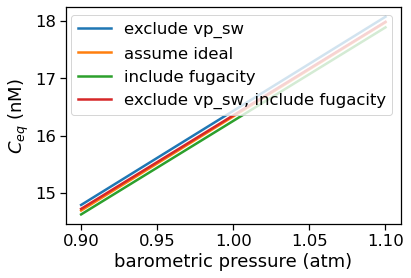

In [10]:
slps = np.linspace(0.9,1.1)
cs1 = []
cs2 = []
cs3 = []
cs4 = []
for slp in slps:
    k0, F, Ceq1 = N2OCeq(33, 0, slp = slp, xn2o=338, watervapor=True, nonideal=True)
    k0, F, Ceq2 = N2OCeq(33, 0, slp = slp, xn2o=338, watervapor=True, nonideal=False)
    k0, F, Ceq3 = N2OCeq(33, 0, slp = slp, xn2o=338, watervapor=False, nonideal=False)
    k0, F, Ceq4 = N2OCeq(33, 0, slp = slp, xn2o=338, watervapor=False, nonideal=True)
    cs1.append(Ceq1)
    cs2.append(Ceq2)
    cs3.append(Ceq3)
    cs4.append(Ceq4)
    
fig, ax = plt.subplots()
ax.plot(slps, np.array(cs3), label = "exclude vp_sw")
ax.plot(slps, np.array(cs2), label = "assume ideal")
ax.plot(slps, np.array(cs1), label = "include fugacity")
ax.plot(slps, np.array(cs4), label = "exclude vp_sw, include fugacity")
ax.legend()
ax.set_xlabel("barometric pressure (atm)")
ax.set_ylabel("$C_{eq}$ (nM)")
plt.show()

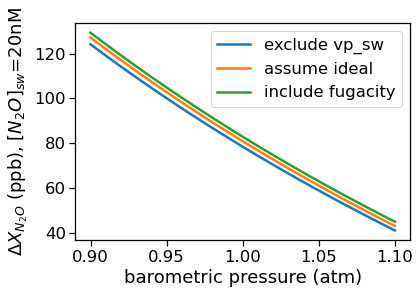

In [11]:
slps = np.linspace(0.9,1.1)
x1 = []
x2 = []
x3 = []
for slp in slps:
    k0, F, xN2O1 = xN2Osw(33, 0, 20, slp = slp, watervapor=True, nonideal=True)
    k0, F, xN2O2 = xN2Osw(33, 0, 20, slp = slp, watervapor=True, nonideal=False)
    k0, F, xN2O3 = xN2Osw(33, 0, 20, slp = slp, watervapor=False, nonideal=False)
    x1.append(xN2O1)
    x2.append(xN2O2)
    x3.append(xN2O3)
    
fig, ax = plt.subplots()
ax.plot(slps, np.array(x3)-333, label = "exclude vp_sw")
ax.plot(slps, np.array(x2)-333, label = "assume ideal")
ax.plot(slps, np.array(x1)-333, label = "include fugacity")
ax.legend()
ax.set_xlabel("barometric pressure (atm)")
ax.set_ylabel("$\Delta X_{N_2O}$ (ppb), $[N_2O]_{sw}$=20nM")
plt.show()

Text(0.5, 0, 'potential temperature ($\\degree C$)')

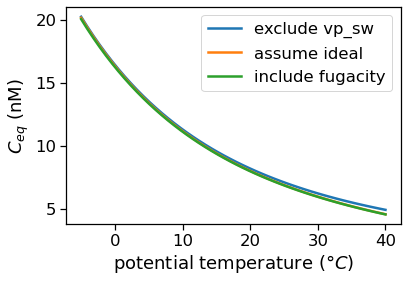

In [12]:
temps = np.linspace(-5,40)
cs1 = []
cs2 = []
cs3 = []
cdiff = []
for t in temps:
    k0, F, Ceq1 = N2OCeq(33, t, slp = 1.0, xn2o=338, watervapor=True, nonideal=True)
    k0, F, Ceq2 = N2OCeq(33, t, slp = 1.0, xn2o=338, watervapor=True, nonideal=False)
    k0, F, Ceq3 = N2OCeq(33, t, slp = 1.0, xn2o=338, watervapor=False, nonideal=False)
    cs1.append(Ceq1)
    cs2.append(Ceq2)
    cs3.append(Ceq3)
    cdiff.append(Ceq2 - Ceq1)
    
fig, ax = plt.subplots()
ax.plot(temps, np.array(cs3), label = "exclude vp_sw")
ax.plot(temps, np.array(cs2), label = "assume ideal")
ax.plot(temps, np.array(cs1), label = "include fugacity")
ax.legend()
ax.set_ylabel("$C_{eq}$ (nM)")
ax.set_xlabel("potential temperature ($\degree C$)")

Text(0.5, 0, 'potential temperature ($\\degree C$)')

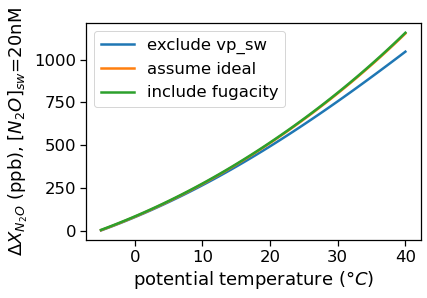

In [13]:
temps = np.linspace(-5,40)
x1 = []
x2 = []
x3 = []
for t in temps:
    k0, F, xN2O1 = xN2Osw(33, t, 20, slp = 1.0, watervapor=True, nonideal=True)
    k0, F, xN2O2 = xN2Osw(33, t, 20, slp = 1.0, watervapor=True, nonideal=False)
    k0, F, xN2O3 = xN2Osw(33, t, 20, slp = 1.0, watervapor=False, nonideal=False)
    x1.append(xN2O1)
    x2.append(xN2O2)
    x3.append(xN2O3)
    
fig, ax = plt.subplots()
ax.plot(temps, np.array(x3)-333, label = "exclude vp_sw")
ax.plot(temps, np.array(x2)-333, label = "assume ideal")
ax.plot(temps, np.array(x1)-333, label = "include fugacity")
ax.legend()
ax.set_ylabel("$\Delta X_{N_2O}$ (ppb), $[N_2O]_{sw}$=20nM")
ax.set_xlabel("potential temperature ($\degree C$)")

Text(0, 0.5, '$pN_2O_{atm}$')

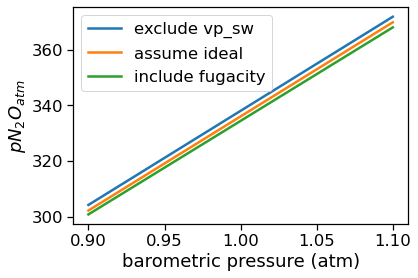

In [14]:
slps = np.linspace(0.9,1.1)
p1s = []
p2s = []
p3s = []
cdiff1 = []
cdiff2 = []
for slp in slps:
    pN2Oatm1 = pN2Oatm(33, 0, slp = slp, xn2o=338, watervapor=True, nonideal=True)
    pN2Oatm2 = pN2Oatm(33, 0, slp = slp, xn2o=338, watervapor=True, nonideal=False)
    pN2Oatm3 = pN2Oatm(33, 0, slp = slp, xn2o=338, watervapor=False, nonideal=False)
    p1s.append(pN2Oatm1)
    p2s.append(pN2Oatm2)
    p3s.append(pN2Oatm3)
    cdiff1.append(pN2Oatm2 - pN2Oatm1)
    cdiff2.append(pN2Oatm3 - pN2Oatm1)
    
fig, ax = plt.subplots()
ax.plot(slps, np.array(p3s), label = "exclude vp_sw")
ax.plot(slps, np.array(p2s), label = "assume ideal")
ax.plot(slps, np.array(p1s), label = "include fugacity")
ax.legend()
ax.set_xlabel("barometric pressure (atm)")
ax.set_ylabel("$pN_2O_{atm}$")

Text(0, 0.5, '$\\Delta pN_2O$, $[N_2O]_{sw}$=20 nM')

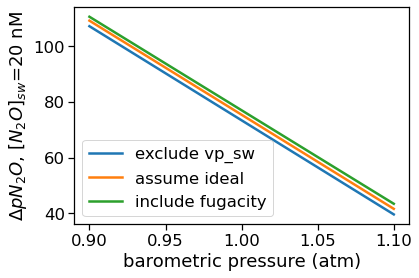

In [15]:
slps = np.linspace(0.9,1.1)
p1s = []
p2s = []
p3s = []
p4s = []
cdiff1 = []
cdiff2 = []
for slp in slps:
    pN2Oatm1 = pN2Oatm(33, 0, slp = slp, xn2o=338, watervapor=True, nonideal=True)
    pN2Oatm2 = pN2Oatm(33, 0, slp = slp, xn2o=338, watervapor=True, nonideal=False)
    pN2Oatm3 = pN2Oatm(33, 0, slp = slp, xn2o=338, watervapor=False, nonideal=False)
    p4s.append(pN2Osw(33,0,20))
    p1s.append(pN2Oatm1)
    p2s.append(pN2Oatm2)
    p3s.append(pN2Oatm3)
    cdiff1.append(pN2Oatm2 - pN2Oatm1)
    cdiff2.append(pN2Oatm3 - pN2Oatm1)
    
fig, ax = plt.subplots()
ax.plot(slps, np.array(p4s) - np.array(p3s), label = "exclude vp_sw")
ax.plot(slps, np.array(p4s) - np.array(p2s), label = "assume ideal")
ax.plot(slps, np.array(p4s) - np.array(p1s), label = "include fugacity")
ax.legend()
ax.set_xlabel("barometric pressure (atm)")
ax.set_ylabel("$\Delta pN_2O$, $[N_2O]_{sw}$=20 nM")

Text(0, 0.5, '$pN_2O_{atm}$')

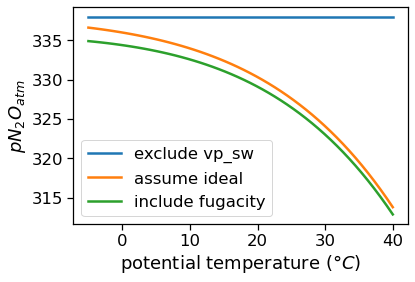

In [16]:
temps = np.linspace(-5, 40)
p1s = []
p2s = []
p3s = []
cdiff1 = []
cdiff2 = []
for t in temps:
    pN2Oatm1 = pN2Oatm(33, t, slp = 1.0, xn2o=338, watervapor=True, nonideal=True)
    pN2Oatm2 = pN2Oatm(33, t, slp = 1.0, xn2o=338, watervapor=True, nonideal=False)
    pN2Oatm3 = pN2Oatm(33, t, slp = 1.0, xn2o=338, watervapor=False, nonideal=False)
    p1s.append(pN2Oatm1)
    p2s.append(pN2Oatm2)
    p3s.append(pN2Oatm3)
    cdiff1.append(pN2Oatm2 - pN2Oatm1)
    cdiff2.append(pN2Oatm3 - pN2Oatm1)
    
fig, ax = plt.subplots()
ax.plot(temps, np.array(p3s), label = "exclude vp_sw")
ax.plot(temps, np.array(p2s), label = "assume ideal")
ax.plot(temps, np.array(p1s), label = "include fugacity")
ax.legend()
ax.set_xlabel("potential temperature ($\degree C$)")
ax.set_ylabel("$pN_2O_{atm}$")

Text(0, 0.5, '$\\Delta pN_2O$, $[N_2O]_{sw}$=20 nM')

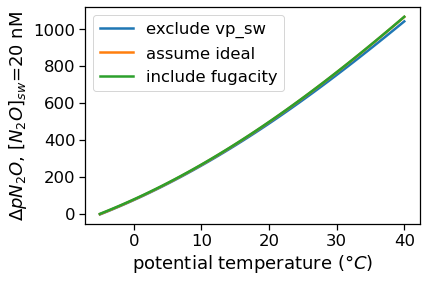

In [17]:
temps = np.linspace(-5, 40)
p1s = []
p2s = []
p3s = []
p4s = []
cdiff1 = []
cdiff2 = []
for t in temps:
    pN2Oatm1 = pN2Oatm(33, t, slp = 1.0, xn2o=338, watervapor=True, nonideal=True)
    pN2Oatm2 = pN2Oatm(33, t, slp = 1.0, xn2o=338, watervapor=True, nonideal=False)
    pN2Oatm3 = pN2Oatm(33, t, slp = 1.0, xn2o=338, watervapor=False, nonideal=False)
    p4s.append(pN2Osw(33,t,20))
    p1s.append(pN2Oatm1)
    p2s.append(pN2Oatm2)
    p3s.append(pN2Oatm3)
    cdiff1.append(pN2Oatm2 - pN2Oatm1)
    cdiff2.append(pN2Oatm3 - pN2Oatm1)
    
fig, ax = plt.subplots()
ax.plot(temps, np.array(p4s) - np.array(p3s), label = "exclude vp_sw")
ax.plot(temps, np.array(p4s) - np.array(p2s), label = "assume ideal")
ax.plot(temps, np.array(p4s) - np.array(p1s), label = "include fugacity")
ax.legend()
ax.set_xlabel("potential temperature ($\degree C$)")
ax.set_ylabel("$\Delta pN_2O$, $[N_2O]_{sw}$=20 nM")

In [30]:
p = 1 * units.atm
T = 20 * units.degC
rh = 1.0
xH2O = mixing_ratio_from_relative_humidity(p, T, rh).to('g/kg')
density(p, T, xH2O * units('g/kg'))

1.2041180947480494 <Unit('kilogram / meter ** 3')>

In [26]:
p = 1000. * units.hPa
T = 28.1 * units.degC
rh = .65
mixing_ratio_from_relative_humidity(p, T, rh).to('g/kg')

15.764696916938787 <Unit('gram / kilogram')>

In [33]:
RatmLmolK = 0.082057366080960

In [50]:
def kinematic_viscosity_air(air_temperature, pressure, rh=1.0):
    """
    Calculate the kinematic viscosity of air given the air temperature, pressure, and 100% relative humidity.

    Parameters:
        air_temperature (float): Air temperature in degrees Celsius.
        pressure (float): Pressure in atm.

    Returns:
        float: Kinematic viscosity of air in m^2/s.
    """
    # Convert air temperature to Kelvin
    T = air_temperature + 273.15
    
    # calculate mixing ratio of water vapor in air
    xH2O = mixing_ratio_from_relative_humidity(pressure * units.atm, air_temperature * units.degC, rh).to('g/kg')
    
    # Calculate density of air
    rho_a = density(pressure * units.atm, air_temperature * units.degC, xH2O * units('g/kg')) 
    
    # Calculate absolute viscosity of air using Sutherland's formula
    mu_a = (1.458e-6 * T**1.5) / (T + 110.4) * units('kg/m/s') # units are kg/m/s
    
    # calculate kinematic viscosity of air
    nu_a = mu_a / rho_a
    
    return mu_a, nu_a

# Example usage:
air_temperature = 20  # degrees Celsius
pressure = 1          # atm

# Calculate kinematic viscosity of air
mu_a, nu_a = kinematic_viscosity_air(20,1,)
print("Kinematic viscosity of air:", nu_a)

Kinematic viscosity of air: 1.5060033480588647e-05 meter ** 2 / second


In [48]:
mu_a.units

<Unit('kilogram / meter / second')>

In [49]:
nu_a.units

<Unit('meter ** 2 / second')>

In [51]:
nu_a

1.5060033480588647e-05 <Unit('meter ** 2 / second')>

In [56]:
def air_side_Schmidt_number(air_temperature, pressure, rh=1.0, gas=None):
    """
    Calculate the air-side Schmidt number for nitrous oxide (N2O).

    Parameters:
        air_temperature (float): Air temperature in degrees Celsius.
        sea_level_pressure (float): Sea level pressure in atm.

    Returns:
        float: Air-side Schmidt number for nitrous oxide (N2O).
    """
    # Coefficients of di§usivity (cm2/s) of selected gases in air, Massman 1998
    diffusivities = {
        'H2O': 0.2178,
        'CO2': 0.1381,
        'CH4': 0.1952,
        'CO': 0.1807, # From Blanc’s law and D(0, 1) for gas in N2 and in O2.
        'SO2': 0.1089, # Based on combining two data points: one for air and one for N2.
        'O3': 0.1444,
        'NH3': 0.1978, # Wintergerst (1930).
        'N2O': 0.1436
    }
    
    # Convert air temperature to Kelvin
    T = air_temperature + 273.15
    
    # Constants for N2O
    molecular_diffusivity = diffusivities[gas]*1e-4 * units('m2/s')  # convert from cm^2/s to m2/s
    
    # Calculate air-side Schmidt number
    mu_a, nu_a = kinematic_viscosity_air(air_temperature, pressure, rh)
    ScA = nu_a / molecular_diffusivity
    
    return ScA

# Example usage:
air_temperature = 20  # degrees Celsius
sea_level_pressure = 1  # atm

ScA_N2O = air_side_Schmidt_number(air_temperature, sea_level_pressure, gas="N2O")
print("Air-side Schmidt number for N2O:", ScA_N2O)

Air-side Schmidt number for N2O: 1.0487488496231647 dimensionless


In [57]:
ScA_CO2 = air_side_Schmidt_number(air_temperature, sea_level_pressure, gas="CO2")
print("Air-side Schmidt number for CO2:", ScA_CO2)

Air-side Schmidt number for CO2: 1.0905165445755718 dimensionless
